# Starbucks Capstone Challenge (ML Part)
This is the second half of the Starbucks Capstone Challenge. In this "ML" notebook, I will load the cleaned and merged data from ETL notebook, train a machine learning model to predict whether a customer will view/complete BOGO and discount offers based on their demographic features. More information can be found in the "introduction" listed in the ETL notebook. 
### Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)

In [307]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import pickle

!ln -s /Users/zhaoli/Desktop/UdacityDS/Starbucks_capstone/visuals.py visuals.py
import visuals as vs

ln: visuals.py: File exists


In [48]:
# load merged bogo data from database
engine = create_engine('sqlite:///Merged_bogo_df.db')
df_bogo = pd.read_sql("SELECT * FROM Merged_bogo", engine)

In [49]:
# load merged discount data from database
engine = create_engine('sqlite:///Merged_discount_df.db')
df_discount = pd.read_sql("SELECT * FROM Merged_discount", engine)

### 1. Study by multiple linear regression

In [137]:
def multi_linear_regression(df, dependent_column):
    df['intercept']=1
    lm = sm.OLS(df[dependent_column], df[['intercept', 'age', 'income', 'membership_days', 'gender_M', 'gender_F']])
    result = lm.fit()
    return result.summary()

In [138]:
print('The multiple linear regression fitting results for BOGO offers view rate is: ')
print(multi_linear_regression(df_bogo, 'view rate'))
print('\n\nThe multiple linear regression fitting results for BOGO offers complete rate is: ')
print(multi_linear_regression(df_bogo, 'complete rate'))

The multiple linear regression fitting results for BOGO offers view rate is: 
                            OLS Regression Results                            
Dep. Variable:              view rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.352
Date:                Thu, 28 Jan 2021   Prob (F-statistic):             0.0383
Time:                        15:42:02   Log-Likelihood:                -2526.1
No. Observations:               13082   AIC:                             5064.
Df Residuals:                   13076   BIC:                             5109.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [58]:
print('The multiple linear regression fitting results for Discout offers view rate is: ')
print(multi_linear_regression(df_discount, 'view rate'))
print('\n\nThe multiple linear regression fitting results for Discount offers complete rate is: ')
print(multi_linear_regression(df_discount, 'complete rate'))

The multiple linear regression fitting results for Discout offers view rate is: 
                            OLS Regression Results                            
Dep. Variable:              view rate   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     34.39
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           4.83e-35
Time:                        13:28:25   Log-Likelihood:                -5570.6
No. Observations:               13042   AIC:                         1.115e+04
Df Residuals:                   13036   BIC:                         1.120e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In the above multiple linear regression model, I learned:  
(1) The R-squared values of the fitting are not very high: the highest is for "BOGO offers complete rate", which is 0.123; the lowest is for "BOGO offers view rate", which is 0.001. It suggests that our features "age", "income", "membership_days", and "gender" do not explain the dependent variables "complete rate" or "view rate" much.  
(2) For the two fittings with relatively higher R-squared values: "BOGO offers complete rate" with R-squared equals to 0.123, and "Discount offers complete rate" with R-squared equals to 0.095, "age", "income", and "membership_days" gives positive coefficients, while both "gender_M" and "gender_F" has negative effect (compared to "gender_O" meaning "others").  
(3) As shown in the warning message, there may be multicollinearity or other numerical problems. So I will do some quick checks in the following. 

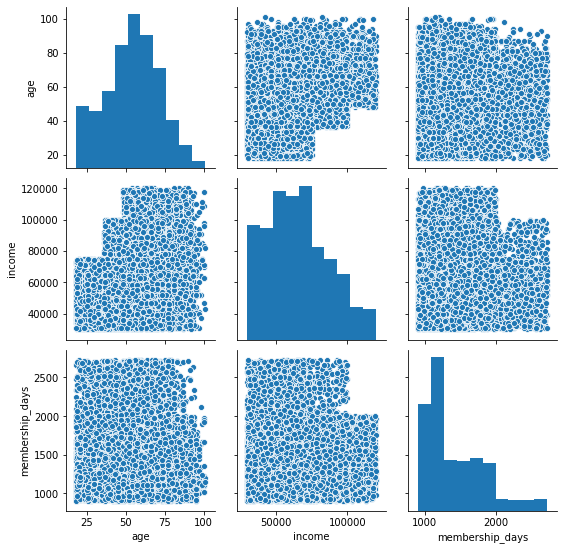

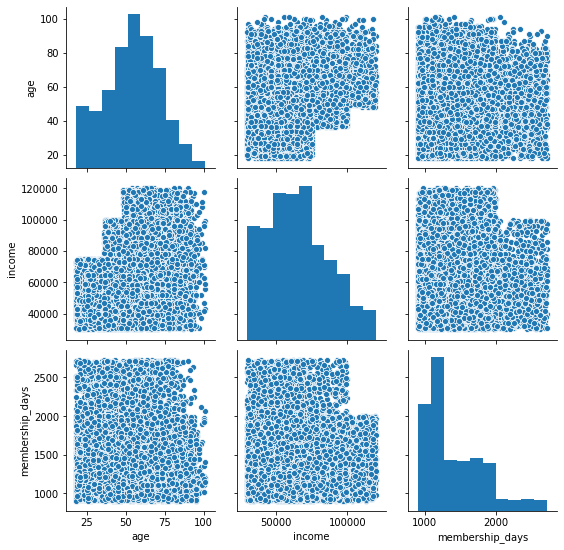

In [63]:
sns.pairplot(df_bogo[['age', 'income', 'membership_days']])
sns.pairplot(df_discount[['age', 'income', 'membership_days']])

It does not appear to me that there are strong correlation between "age", "income", and "membership_days". However, it's worth noting that almost no young customer has higher than 80000 or 100000 dollars income, and almost no customer with higher than 100000 dollars income has a membership more than 2000 days. Now let's calculate the VIF (variance inflation factor) for features "age", "income", and "membership_days":

In [64]:
# VIF dataframe 
vif_data = pd.DataFrame() 
X = df_bogo[['age', 'income', 'membership_days']]
vif_data["feature"] = X.columns

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

           feature       VIF
0              age  9.538494
1           income  9.327670
2  membership_days  7.361293


In [65]:
vif_data = pd.DataFrame() 
X = df_discount[['age', 'income', 'membership_days']]
vif_data["feature"] = X.columns

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

           feature       VIF
0              age  9.504762
1           income  9.369678
2  membership_days  7.381204


Based on chapter 3 of the book "An Introduction to Statistical Learning with Applications in R" (by Gareth James , Daniela Witten , Trevor Hastie, and Robert Tibshirani), "The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity". Here in our dataframe, the VIF values are close to 10, which indicate some degree of collinearity. 

The following heat map also shows some correlation between the features in the dataframe:

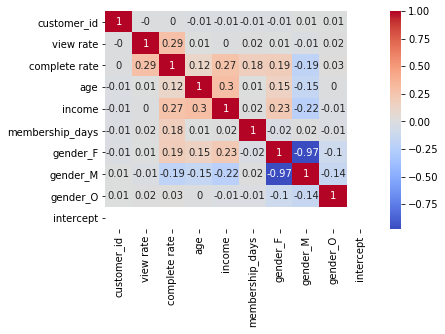

In [30]:
corr_matrix = df_bogo.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

### 2. Study by random forest classifier

The question that I asked at the beginning of this project is "How to find the best target of BOGO and discount offers?" So in the following I will use train a random forest classifier and use it to predict if a customer would complete a BOGO or a discount offer based on their demographic features, such as age, income, membership_days, and gender. 

#### 2.1 "complete rate" for BOGO offers

In [293]:
def rf_classifier(df, dependent_column, threshold=1, test_size=0.2, random_state=42, n_estimators=100, max_depth=100, min_samples_leaf=1):
    '''
    INPUT:
    df - (pandas dataframe) dataframe to with individual's information on age, income, and membership_days
    dependennt_column - (str) name of the column contains the dependent variable I want to study
    threshold - (num between 0 and 1) the threshold rate equal or above which a customer 
                is labeled as positive target ("1"); default is 100% rate
    test_size - (num between 0 and 1) percentage of dataset to be assigned to the test group
    random_state - (num) random seed
    n_estimators, max_depth, min_samples_leaf - three parameters will be studied in this 
                preliminary step to see how parameters affect the accuracy of prediction
                
    OUTPUT:
    model.score - (float) accuracy of the predictions on the train and test datasets
    
    Description:
    This is a function to train a random forest classifier model on the input dataframe 
    (with the possibility to finetune the model with three parameters "n_estimators",
    "max_depth", and "min_samples_leaf"), and use the model to make predictions on both
    training and testing datasets, and return the accuracy scores for these predictions
    
    '''
    X = df[['age', 'income', 'membership_days', 'gender_F', 'gender_M', 'gender_O']]
    y = df[dependent_column]
    # because I am using "classifier" now, I will convert the result into binary: 
    # "1" for ">= threshold" (default is 100%) and "0" for "< threshold"
    y = (y>=threshold).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    
    print(f'Accuracy of RF classifier on training set: {round(model.score(X_train, y_train)*100,2)}%.')
    print(f'Prediction Accuracy: {round(model.score(X_test, y_test)*100,2)}%.')
    
    return model.score(X_train, y_train), model.score(X_test, y_test)

In the following cells, I will first investigate on improving the predictio accuracy by tuning parameters "n_estimators", "max_depth", and "min_sample_leaf":

10
Accuracy of RF classifier on training set: 97.93%.
Prediction Accuracy: 62.78%.
0.9792964631457874
20
Accuracy of RF classifier on training set: 99.4%.
Prediction Accuracy: 63.66%.
0.9939614684175213
30
Accuracy of RF classifier on training set: 99.78%.
Prediction Accuracy: 64.16%.
0.9977954567238569
40
Accuracy of RF classifier on training set: 99.85%.
Prediction Accuracy: 63.89%.
0.9984664046774657
50
Accuracy of RF classifier on training set: 99.89%.
Prediction Accuracy: 64.55%.
0.9989456532157577
60
Accuracy of RF classifier on training set: 99.93%.
Prediction Accuracy: 64.62%.
0.9993290520463912
70
Accuracy of RF classifier on training set: 99.94%.
Prediction Accuracy: 64.78%.
0.9994249017540496
80
Accuracy of RF classifier on training set: 99.95%.
Prediction Accuracy: 64.85%.
0.999520751461708
90
Accuracy of RF classifier on training set: 99.95%.
Prediction Accuracy: 64.7%.
0.999520751461708
100
Accuracy of RF classifier on training set: 99.95%.
Prediction Accuracy: 64.55%.
0.

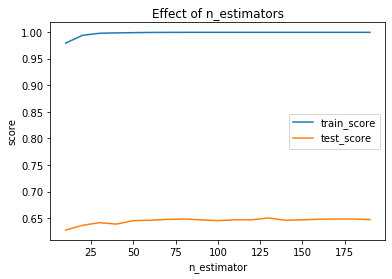

In [152]:
estimators = np.arange(10, 200, 10)
train_scores = []
test_scores = []
for n in estimators:
    train_score, test_score = rf_classifier(df_bogo, 'complete rate',n_estimators=n)
    train_scores.append(train_score)
    test_scores.append(test_score)
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, train_scores,label='train_score')
plt.plot(estimators, test_scores, label='test_score')
plt.legend(loc='best')
plt.show()

5
Accuracy of RF classifier on training set: 70.96%.
Prediction Accuracy: 69.93%.
6
Accuracy of RF classifier on training set: 71.68%.
Prediction Accuracy: 69.62%.
7
Accuracy of RF classifier on training set: 72.35%.
Prediction Accuracy: 69.47%.
8
Accuracy of RF classifier on training set: 73.62%.
Prediction Accuracy: 69.93%.
9
Accuracy of RF classifier on training set: 75.48%.
Prediction Accuracy: 69.74%.
10
Accuracy of RF classifier on training set: 77.01%.
Prediction Accuracy: 69.62%.
11
Accuracy of RF classifier on training set: 79.53%.
Prediction Accuracy: 69.58%.
12
Accuracy of RF classifier on training set: 82.05%.
Prediction Accuracy: 68.74%.
13
Accuracy of RF classifier on training set: 85.06%.
Prediction Accuracy: 68.78%.
14
Accuracy of RF classifier on training set: 87.95%.
Prediction Accuracy: 68.55%.


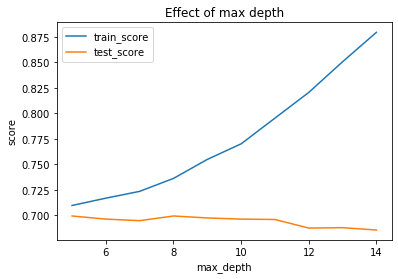

In [174]:
depths = np.arange(5,15)
train_scores = []
test_scores = []
for d in depths:
    print(d)
    train_score, test_score = rf_classifier(df_bogo, 'complete rate', n_estimators=50, max_depth=d)
    train_scores.append(train_score)
    test_scores.append(test_score)
plt.title("Effect of max depth")
plt.xlabel("max_depth")
plt.ylabel("score")
plt.plot(depths, train_scores,label='train_score')
plt.plot(depths, test_scores, label='test_score')
plt.legend(loc='best')
plt.show()

1
Accuracy of RF classifier on training set: 99.91%.
Prediction Accuracy: 66.72%.
2
Accuracy of RF classifier on training set: 93.05%.
Prediction Accuracy: 67.71%.
3
Accuracy of RF classifier on training set: 87.13%.
Prediction Accuracy: 68.25%.
4
Accuracy of RF classifier on training set: 83.23%.
Prediction Accuracy: 68.55%.
5
Accuracy of RF classifier on training set: 80.51%.
Prediction Accuracy: 69.05%.
6
Accuracy of RF classifier on training set: 79.01%.
Prediction Accuracy: 69.7%.
7
Accuracy of RF classifier on training set: 77.74%.
Prediction Accuracy: 69.28%.
8
Accuracy of RF classifier on training set: 76.79%.
Prediction Accuracy: 69.05%.
9
Accuracy of RF classifier on training set: 75.96%.
Prediction Accuracy: 69.32%.


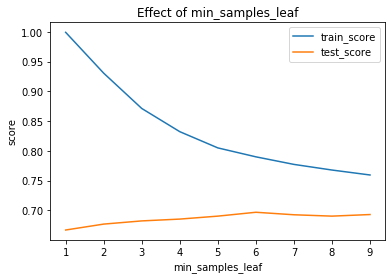

In [294]:
leaves = np.arange(1,10)
train_scores = []
test_scores = []
for leaf in leaves:
    print(leaf)
    train_score, test_score = rf_classifier(df_bogo, 'complete rate', n_estimators=50, min_samples_leaf=leaf)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
plt.title("Effect of min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("score")
plt.plot(leaves, train_scores,label='train_score')
plt.plot(leaves, test_scores, label='test_score')
plt.legend(loc='best')
plt.show()

From the above preliminary studies, I found tuning these parameters helps avoid overfitting and improve accuracy. So here I am doing a grid search to find optimal parameters:

In [299]:
def clf_grid_search(df, dependent_column, parameters, threshold=1, test_size=0.2, random_state=42):
    '''
    INPUT:
    df - (pandas dataframe) dataframe to with individual's information on age, income, and membership_days
    dependennt_column - (str) name of the column contains the dependent variable I want to study
    parameters - (dict) parameters in the grid search to optimize the model
    threshold - (num between 0 and 1) the threshold rate equal or above which a customer 
                is labeled as positive target ("1"); default is 100% rate
    test_size - (num between 0 and 1) percentage of dataset to be assigned to the test group
    random_state - (num) random seed
                
    OUTPUT:
    best_clf - best classifier found by the grid search
    
    Description:
    This is a function to train a random forest classifier model on the input dataframe, 
    and use the model to make predictions on the testing datasets. 
    A grid search is included to find the optimized model.
    Accuracy and F1-score of the best model will be printed.
    '''
    
    X = df[['age', 'income', 'membership_days', 'gender_F', 'gender_M', 'gender_O']]
    y = df[dependent_column]
    # because I am using "classifier" now, I will convert the result into binary: 
    # "1" for ">= threshold" (default is 100%) and "0" for "< threshold"
    y = (y>=threshold).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # initiate a random forest clf
    model = RandomForestClassifier(random_state=random_state)
    
    # make an fbeta_score scoring object using make_scorer()
    scorer = make_scorer(fbeta_score, beta = 0.5)
    
    # perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
    grid_obj = GridSearchCV(model, parameters, scoring = scorer, verbose=5)
    
    # fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)
    
    # get the estimator
    best_clf = grid_fit.best_estimator_
    
    # make predictions using the unoptimized and model
    predictions = (model.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # print the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    
    return best_clf

In [295]:
parameters = {'max_depth': [4, 6, 8], 
              'min_samples_split': [2, 3, 4], 
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [90, 100, 110, 120]}
best_clf = clf_grid_search(df_bogo, 'complete rate', parameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.666, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.688, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.684, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.683, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.662, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.665, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.688, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.683, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.686, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.661, 

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.666, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.688, total=   0.7s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.685, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.686, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.663, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.665,

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.688, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.686, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.684, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.661, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.667, total=   0.3s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.687, tot

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.685, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.682, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.661, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.667, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.685, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.686, tota

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.687, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.662, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.669, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.676, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.688, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.685,

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.663, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.668, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.679, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.685, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.684, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.664,

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.665, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.674, total=   0.7s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.691, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.680, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.660, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.663, total=  

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.675, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.685, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.684, total=   0.5s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.661, total=   0.5s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.667, total=   0.5s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.678,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.680, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.678, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.660, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.654, total=   0.7s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.673, total=   0.6s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.680,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.674, total=   0.6s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.660, total=   0.6s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.655, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.681, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.676, total=   0.6s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.679, total= 

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.658, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.653, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.680, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.677, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.682, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.658, 

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.658, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.678, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.679, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.683, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.663, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120, score=0.657,

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  4.0min finished


Unoptimized model
------
Accuracy score on testing data: 0.6618
F-score on testing data: 0.6434

Optimized Model
------
Final accuracy score on the testing data: 0.6985
Final F-score on the testing data: 0.6902


In [298]:
best_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Through a grid search, my model can achieve a 0.6985 accuracy score and a 0.6902 F1 score when predicting on the test set. Let's see the normalized weights for the most predictive features using the optimized model found in the grid search:

[0.04788303 0.25208105 0.54255659 0.05746327 0.09718781 0.00282824]


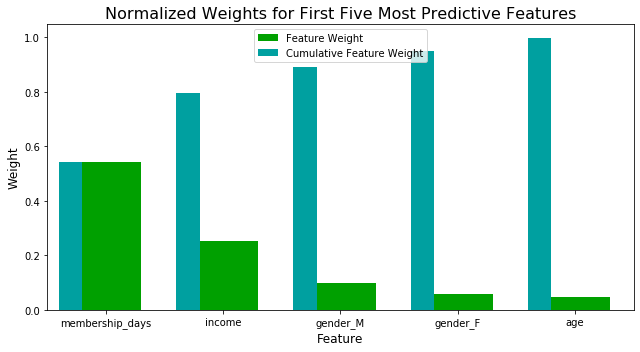

In [300]:
importances = best_clf.feature_importances_
print(importances)
vs.feature_plot(importances, X_train, y_train)
# Note: "vs" code comes from "Udacity Machine Learning Nanodegree Program" that I took last year. 
# It helps visualize the top predictive features and their weights in the model.

The five most predictive features for "complete rate" for the BOGO discount are "membership_days" (54.3%), "income" (25.2%), "gender_M" (9.7%), "gender_F" (5.7%) and "age" (4.8%). 

In the following, I will train random forest classifiers for "view rate" for BOGO offers, and both "complete rate" and "view rate" for discount offers:

#### 2.2 "view rate" for BOGO offers

In [301]:
parameters = {'max_depth': [4, 6, 8], 
              'min_samples_split': [2, 3, 4], 
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [90, 100, 110, 120]}
best_clf = clf_grid_search(df_bogo, 'view rate', parameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.750, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.750, 

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.750,

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.750, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.750, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.750, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.750, tot

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.750, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.750, tota

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.750, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.750, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.751,

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.750, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.752, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.750, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.750,

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.751, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.751, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.750, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.751, total=  

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.749, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.751, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.751,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.751, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.752, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.748, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.752, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.749, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.751,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.752, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.748, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.751, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.749, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.750, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.752, total= 

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.749, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.752, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.749, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.750, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.752, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.749, 

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.751, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.749, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.751, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.753, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.749, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120, score=0.751,

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.5min finished


Unoptimized model
------
Accuracy score on testing data: 0.6523
F-score on testing data: 0.7331

Optimized Model
------
Final accuracy score on the testing data: 0.7019
Final F-score on the testing data: 0.7466


To predict "view rate" for BOGO offers, through the grid search, my model achieves a higher accuracy and F1-score of 0.7019 and 0.7466, respectively. 

[0.24950527 0.44960072 0.2490593  0.01678777 0.01919371 0.01585325]


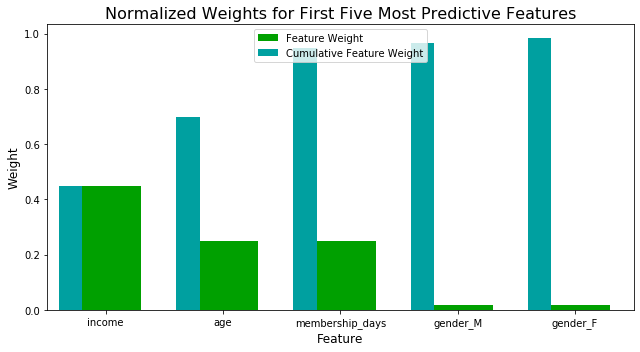

In [302]:
importances = best_clf.feature_importances_
print(importances)
vs.feature_plot(importances, X_train, y_train)

It's interesting to see that to the three most predictive features for "view rate" for the BOGO discount become "income" (45.0%), "age" (25.0%) and "membership_days" (24.9%), "gender" becomes less important in this prediction. 

#### 2.3 "complete rate" for discount offers

In [303]:
parameters = {'max_depth': [4, 6, 8], 
              'min_samples_split': [2, 3, 4], 
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [90, 100, 110, 120]}
best_clf = clf_grid_search(df_discount, 'complete rate', parameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.714, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.743, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.715, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.719, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.710, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.714, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.743, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.716, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.721, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.710, 

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.714, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.744, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.717, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.719, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.706, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.711,

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.741, total=   0.6s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.715, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.719, total=   0.4s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.705, total=   0.6s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.714, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.741, tot

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.713, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.717, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.709, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.714, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.744, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.715, tota

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.720, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.716, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.722, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.743, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.723, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.718,

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.716, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.723, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.740, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.722, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.721, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.714,

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.722, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.744, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.723, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.719, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.716, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.724, total=  

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.744, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.723, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.720, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.714, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.723, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.744,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.723, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.718, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.710, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.718, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.736, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.723,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.718, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.709, total=   0.7s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.721, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.744, total=   0.6s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.722, total=   0.6s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.716, total= 

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.711, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.721, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.742, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.722, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.716, total=   0.6s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.709, 

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.721, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.739, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.720, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.714, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.714, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120, score=0.720,

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  4.0min finished


Unoptimized model
------
Accuracy score on testing data: 0.6455
F-score on testing data: 0.6833

Optimized Model
------
Final accuracy score on the testing data: 0.6742
Final F-score on the testing data: 0.7087


To predict "complete rate" for discount offers, through a grid search, my model achieves an accuracy and F1-score of 0.6742 and 0.7087, respectively. 

[0.06631287 0.12760556 0.73988613 0.02521706 0.03892058 0.0020578 ]


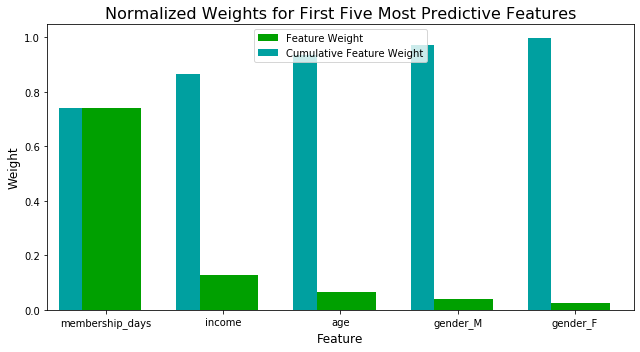

In [304]:
importances = best_clf.feature_importances_
print(importances)
vs.feature_plot(importances, X_train, y_train)

WOW! "membership_days" is the predominant feature (74.0%) to predict whether a customer will complete the discount offers they received. "income" has 12.8% weights to the prediction, while "age" has 6.6% weight. 

#### 2.4 "view rate" for discount offers

In [305]:
parameters = {'max_depth': [4, 6, 8], 
              'min_samples_split': [2, 3, 4], 
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [90, 100, 110, 120]}
best_clf = clf_grid_search(df_discount, 'view rate', parameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.625, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.630, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.638, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.641, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.632, total=   0.4s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.625, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.632, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.638, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.642, total=   0.3s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.632, 

[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.625, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.631, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.639, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.641, total=   0.6s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.631, total=   0.5s
[CV] max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.625,

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.631, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.637, total=   0.6s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.641, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=3, n_estimators=120, score=0.632, total=   0.5s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.625, total=   0.3s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.631, tot

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.638, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.640, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=90, score=0.631, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.625, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.631, total=   0.3s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.638, tota

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.650, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.645, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.633, total=   0.6s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.633, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.641, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.649,

[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=110, score=0.639, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.631, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.633, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.643, total=   0.5s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.649, total=   0.4s
[CV] max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.641,

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.631, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.632, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.641, total=   0.5s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.648, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.640, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.631, total=  

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.635, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.641, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.649, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=100, score=0.644, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.631, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.635,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.642, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.650, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=110, score=0.645, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.625, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.633, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=120, score=0.642,

[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.650, total=   0.5s
[CV] max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=1, min_samples_split=4, n_estimators=120, score=0.645, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.623, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.631, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.642, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.646, total= 

[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.645, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.624, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.631, total=   0.6s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.642, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.649, total=   0.5s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=4, n_estimators=100, score=0.643, 

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.624, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.634, total=   0.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.639, total=   0.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.644, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=110, score=0.643, total=   0.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=3, n_estimators=120, score=0.626,

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.9min finished


Unoptimized model
------
Accuracy score on testing data: 0.5539
F-score on testing data: 0.5758

Optimized Model
------
Final accuracy score on the testing data: 0.6048
Final F-score on the testing data: 0.6227


To predict "view rate" for discount offers, even through a grid search, my model only achieves an accuracy and F1-score of 0.6048 and 0.6227, respectively. If I have more time, I will perform more grid search, and also explore the possibility to use other machine learning models. 

[0.27657847 0.54329063 0.13288893 0.01194503 0.01552771 0.01976923]


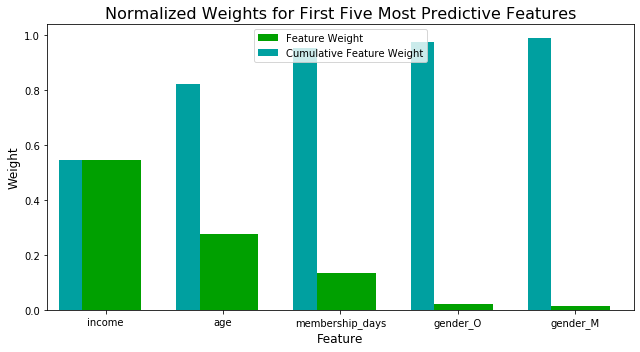

In [306]:
importances = best_clf.feature_importances_
print(importances)
vs.feature_plot(importances, X_train, y_train)

In this case, "income" becomes the most important predictive feature (54.3%), followed by "age" (27.7%) and "membership_days" (13.3%). 

Overall speaking, "membership_days" and "income" appear to be most important predictive features in my model, followed by "age"; "gender" does not weigh much in the prediction. If I have more time, I will do more grid search to find more optimized model.